In [2]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime, timedelta
import calendar

In [17]:
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
# 数据加载
df = pd.read_csv('./shprice.csv',encoding='gbk')
df=df.drop(df.columns[2:],axis=1)

In [18]:
df

,时间(年-月),供给(元/㎡)
0,2019/3/1,52278
1,2019/2/1,53234
2,2019/1/1,53166
3,2018/12/1,52087
4,2018/11/1,51620
...,...,...
56,2014/7/1,30709
57,2014/6/1,29898
58,2014/5/1,30432
59,2014/4/1,30211


In [19]:
# 将时间作为df的索引
df["时间(年-月)"]= pd.to_datetime(df["时间(年-月)"])
df.index = df["时间(年-月)"]
# 数据探索
df=df.drop(df.columns[0],axis=1)
df=df.iloc[::-1]
print(df.head())

            供给(元/㎡)
时间(年-月)            
2014-03-01    29405
2014-04-01    30211
2014-05-01    30432
2014-06-01    29898
2014-07-01    30709


In [21]:

ps = range(0, 5)
qs = range(0, 5)
ds = range(1, 2)
parameters = product(ps, ds, qs)
parameters_list = list(parameters)
# 寻找最优ARMA模型参数，即best_aic最小
results = []
best_aic = float("inf") # 正无穷
for param in parameters_list:
    try:
        #model = ARIMA(df_month.Price,order=(param[0], param[1], param[2])).fit()
        # SARIMAX 包含季节趋势因素的ARIMA模型
        model = sm.tsa.statespace.SARIMAX(df["供给(元/㎡)"],
                                order=(param[0], param[1], param[2]),
                                #seasonal_order=(4, 1, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit()

    except ValueError:
        print('参数错误:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
# 输出最优模型
print('最优模型: ', best_model.summary())

最优模型:                             Statespace Model Results                           
Dep. Variable:                供给(元/㎡)   No. Observations:                   61
Model:               SARIMAX(3, 1, 4)   Log Likelihood                -459.605
Date:                Sun, 26 Apr 2020   AIC                            935.210
Time:                        23:19:00   BIC                            951.269
Sample:                    03-01-2014   HQIC                           941.420
                         - 03-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6911      0.221      7.648      0.000       1.258       2.125
ar.L2         -1.4696      0.364     -4.034      0.000      -2.184      -0.756
ar.L3          0.7234      0.216      3.349  

In [22]:
df2=df[["供给(元/㎡)"]]
df2

,供给(元/㎡)
时间(年-月),
2014-03-01,29405
2014-04-01,30211
2014-05-01,30432
2014-06-01,29898
2014-07-01,30709
...,...
2018-11-01,51620
2018-12-01,52087
2019-01-01,53166


In [40]:
future_month = 3
last_month = pd.to_datetime(df2.index[len(df2)-1])
last_month

Timestamp('2019-03-01 00:00:00')

In [41]:
date_list = []
for i in range(future_month):
    # 计算下个月有多少天
    year = last_month.year
    month = last_month.month
    if month == 12:
        month = 1
        year = year+1
    else:
        month = month + 1
    month_days = calendar.monthrange(year, month-1)[1]
    #print(next_month_days)
    last_month = last_month + timedelta(days=month_days)
    date_list.append(last_month)
print('date_list=', date_list)

date_list= [Timestamp('2019-04-01 00:00:00'), Timestamp('2019-05-01 00:00:00'), Timestamp('2019-06-01 00:00:00')]


In [42]:
# 添加未来要预测的3个月
future = pd.DataFrame(index=date_list, columns= df.columns)
df2 = pd.concat([df2, future])

In [43]:
# get_prediction得到的是区间，使用predicted_mean
df2['forecast'] = best_model.get_prediction(start=0, end=len(df2)).predicted_mean

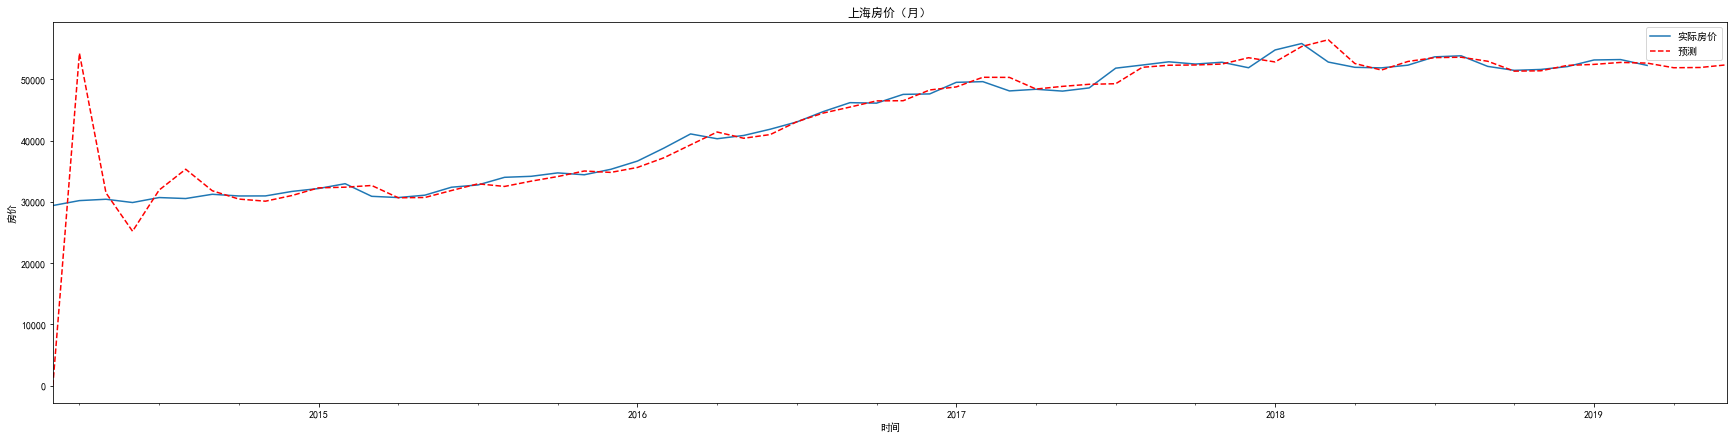

In [44]:

plt.figure(figsize=(30,7))
df2["供给(元/㎡)"].plot(label='实际房价')
df2.forecast.plot(color='r', ls='--', label='预测')
plt.legend()
plt.title('上海房价（月）')
plt.xlabel('时间')
plt.ylabel('房价')
plt.show()


In [46]:
df2

,供给(元/㎡),forecast
2014-03-01,29405,0.000000
2014-04-01,30211,54268.429155
2014-05-01,30432,31465.971270
2014-06-01,29898,25211.248132
2014-07-01,30709,31933.068046
...,...,...
2019-02-01,53234,52767.642097
2019-03-01,52278,52653.583115
2019-04-01,NaN,51899.474426
2019-05-01,NaN,51939.463011
